In [ ]:
############### importing libraries ################
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image_dataset_from_directory, image
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAvgPool2D, RandomRotation, RandomZoom, Rescaling, Dropout, Activation, BatchNormalization, SpatialDropout2D, MaxPool2D, Flatten

## helper functions

In [ ]:
def extract_labels_from_dataset(ds):
    """Return numpy array of labels in the same order as dataset batches."""
    labels = []
    for _, y in ds:
        labels.append(y.numpy())
    labels = np.concatenate(labels, axis=0).ravel()
    return labels.astype(int)

def get_preds_and_probs(model, ds):
    """Return (y_probs, y_pred) for a binary model with sigmoid output."""
    probs = model.predict(ds, verbose=1)
    probs = np.array(probs).ravel()          # shape (N,)
    preds = (probs >= 0.5).astype(int)
    return probs, preds

############################################ visualization function ##############################

def plot_histories_rowwise(histories, labels=None, figsize_per_row=(5, 5), marker='o'):
    """
    Plot multiple Keras histories row-wise. Each row contains two subplots:
      [ Accuracy (train/val) | Loss (train/val) ]

    Args:
      histories: list of keras History objects or dicts (history.history or dict).
      labels:    optional list of labels for each history (defaults to Model 1, Model 2, ...).
      figsize_per_row: tuple (width, height) for each row. Total figsize = (width, height * n_rows).
      marker:    matplotlib marker style for points.
    """
    # Normalize inputs
    if labels is None:
        labels = [f"Model {i+1}" for i in range(len(histories))]
    if len(labels) != len(histories):
        raise ValueError("Length of labels must match number of histories.")

    # Helper to extract arrays, supporting History objects or dicts and 'acc' vs 'accuracy'
    def _get_series(h, key_options):
        """Return series list or None if not present."""
        # unwrap keras History
        if hasattr(h, "history"):
            h = h.history
        for k in key_options:
            if k in h:
                return h[k]
        return None

    n = len(histories)
    width, height_one = figsize_per_row
    fig, axes = plt.subplots(n, 2, figsize=(width, height_one * n), squeeze=False)

    for i, h in enumerate(histories):
        # accuracy keys may be 'accuracy' or 'acc'
        acc = _get_series(h, ['accuracy', 'acc'])
        val_acc = _get_series(h, ['val_accuracy', 'val_acc'])
        loss = _get_series(h, ['loss'])
        val_loss = _get_series(h, ['val_loss'])

        # Determine epoch range from whatever series exists (prefer loss)
        length = None
        for series in (loss, acc, val_acc, val_loss):
            if series is not None:
                length = len(series)
                break
        if length is None:
            raise ValueError(f"No known keys found in history {i}. Expected 'loss' or 'accuracy' keys.")
        epochs = range(1, length + 1)

        # Accuracy subplot (left)
        ax_acc = axes[i, 0]
        if acc is not None:
            ax_acc.plot(epochs, acc[:length], marker=marker, label='train', linestyle='-')
        if val_acc is not None:
            ax_acc.plot(epochs, val_acc[:length], marker=marker, label='val', linestyle='--')
        ax_acc.set_ylim(0, 1)
        ax_acc.set_ylabel('Accuracy')
        if i == n-1:
            ax_acc.set_xlabel('Epochs')
        ax_acc.set_title(f"{labels[i]} — Accuracy")
        ax_acc.grid(True)
        ax_acc.legend()

        # Loss subplot (right)
        ax_loss = axes[i, 1]
        if loss is not None:
            ax_loss.plot(epochs, loss[:length], marker=marker, label='train', linestyle='-')
        if val_loss is not None:
            ax_loss.plot(epochs, val_loss[:length], marker=marker, label='val', linestyle='--')
        ax_loss.set_ylabel('Loss')
        if i == n-1:
            ax_loss.set_xlabel('Epochs')
        ax_loss.set_title(f"{labels[i]} — Loss")
        ax_loss.grid(True)
        ax_loss.legend()

    plt.tight_layout()
    plt.show()


################################################################################################

def evaluate_and_plot(model, dataset, class_names=('NORMAL','PNEUMONIA'), threshold=0.5):
    """
    ---------- Usage ----------
    Assuming `model` is your trained Keras model and `test_ds` is your test dataset
    (make sure test_ds yields labels in the same order your model.predict uses)
    evaluate_and_plot(model, test_ds, class_names=('NORMAL','PNEUMONIA'), threshold=0.5)
    """
    # true labels (must match dataset used in predict)
    y_true = extract_labels_from_dataset(dataset)
    # predicted probs and labels
    probs = np.array(model.predict(dataset, verbose=1)).ravel()
    y_pred = (probs >= threshold).astype(int)

    # Classification report
    print("=== Classification report ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix (counts)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-wise normalization

    # Plot side-by-side: counts and percentages
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix (counts)')

    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix (row-normalized %)')

    plt.tight_layout()
    plt.show()


## Data processing

In [ ]:
######### downloading and preprocessing the data #########

import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

print('\ncontents within the dataset main file:')
! cd /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray && ls
! cd /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val && ls

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia

contents within the dataset main file:
test  train  val
NORMAL	PNEUMONIA


In [ ]:
sample = os.path.join(path, 'chest_xray', 'chest_xray', 'test', 'NORMAL', 'IM-0025-0001.jpeg')
img = image.load_img(sample, target_size=(384, 384)) # Load image and resize
img_array = image.img_to_array(img)
print(img_array.shape)
#print(img_array)

(384, 384, 3)


In [ ]:
###################### defining paths to data ########################

path_train = os.path.join(path, 'chest_xray', 'chest_xray', 'train')
path_test = os.path.join(path, 'chest_xray', 'chest_xray', 'test')
path_val = os.path.join(path, 'chest_xray', 'chest_xray', 'val')
class_names = ['NORMAL', 'PNEUMONIA']
image_size = (img_array.shape[0], img_array.shape[1])

############ prepare train, test, val datasets with keras ##############

print('\ntrain dataset')
train_ds = image_dataset_from_directory(
    directory= path_train,
    image_size=image_size,
    class_names=class_names,
    label_mode='binary', verbose=1
)

print('\ntest dataset')
test_ds = image_dataset_from_directory(
    directory=path_test,
    image_size=image_size,
    class_names=class_names,
    label_mode='binary', verbose=1
)

print('\nval dataset')
val_ds = image_dataset_from_directory(
    directory=path_val,
    image_size=image_size,
    class_names=class_names,
    label_mode='binary', verbose=1
)

print('\n')
print(val_ds.element_spec)


train dataset
Found 5216 files belonging to 2 classes.

test dataset
Found 624 files belonging to 2 classes.

val dataset
Found 16 files belonging to 2 classes.


(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


In [ ]:
import os
from collections import Counter

def count_by_folder(path, classes=['NORMAL','PNEUMONIA']):
    counts = {}
    for c in classes:
        folder = os.path.join(path, c)
        # count common image extensions
        n = sum(len(files) for _, _, files in os.walk(folder))
        counts[c] = n
    total = sum(counts.values())
    for k,v in counts.items():
        print(f"{k}: {v} images ({v/total*100:.2f}%)")
    print(f"Total: {total}\n")
    return counts

print("TRAIN:")
train_counts = count_by_folder(path_train, class_names)

print("VALIDATION:")
val_counts = count_by_folder(path_val, class_names)

print("TEST:")
test_counts = count_by_folder(path_test, class_names)


TRAIN:
NORMAL: 1342 images (25.72%)
PNEUMONIA: 3876 images (74.28%)
Total: 5218

VALIDATION:
NORMAL: 9 images (50.00%)
PNEUMONIA: 9 images (50.00%)
Total: 18

TEST:
NORMAL: 234 images (37.50%)
PNEUMONIA: 390 images (62.50%)
Total: 624



In [ ]:
####################### calculating class weights #####################

class_weight = {
    0: 5218 / (1342*2),
    1: 5218 / (3876*2)
}

print('class weight of NORMAL:', class_weight[0])
print('class weight of PNEUMONIA:', class_weight[1])

class weight of NORMAL: 1.9441132637853948
class weight of PNEUMONIA: 0.6731166150670794


## Model designing and training

In [ ]:
#################################### model1 ####################################
augmentation = Sequential([
    RandomRotation(0.05),
    RandomZoom(0.1)
], name='augmentation')


model = Sequential()

model.add(keras.Input(batch_size=32, shape=(384, 384, 3)))
model.add(augmentation)
model.add(Rescaling(1.0 / 225.0))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(SpatialDropout2D(0.05))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(SpatialDropout2D(0.15))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(SpatialDropout2D(0.2))

model.add(GlobalAvgPool2D())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()


model.compile(
    optimizer=keras.optimizers.Adam(0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (32, 384, 384, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 384, 384, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 384, 384, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 384, 384, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 384, 384, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 192, 192, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (32, 192, 192, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 192, 192, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 192, 192, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (32, 192, 192, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 96, 96, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (32, 96, 96, 64)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 96, 96, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 96, 96, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (32, 96, 96, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 48, 48, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (32, 48, 48, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 128)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
epochs = 12

callbacks = [ModelCheckpoint(
    filepath="model1.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1)]

history_1 = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    verbose=1,
    callbacks = [callbacks],
    class_weight = class_weight
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4945 - loss: 1.6263
Epoch 1: val_loss improved from inf to 1.06905, saving model to model1.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 459ms/step - accuracy: 0.4948 - loss: 1.6221 - val_accuracy: 0.3974 - val_loss: 1.0690
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5845 - loss: 0.6631
Epoch 2: val_loss improved from 1.06905 to 0.69972, saving model to model1.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 454ms/step - accuracy: 0.5845 - loss: 0.6630 - val_accuracy: 0.6394 - val_loss: 0.6997
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6352 - loss: 0.6272
Epoch 3: val_loss did not improve from 0.69972
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 437ms/step - accuracy: 0.6351 - loss: 0.6271 - val_accuracy: 0.3766 - val_loss: 0.8655
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6518 - loss: 0.5818
Epoch 4: val_loss improved from 0.69972 to 0.66895, saving model to model1.keras
16

In [ ]:
###################################### model 2 ####################################33
model_2 = Sequential()

model_2.add(keras.Input(batch_size=32, shape=(384, 384,3)))
model_2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(Dropout(0.1))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(GlobalAvgPool2D())
model_2.add(Dense(units = 128 , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(units = 1 , activation = 'sigmoid'))
model_2.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (32, 384, 384, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 384, 384, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 192, 192, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 192, 192, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 192, 192, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 192, 192, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 96, 96, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 96, 96, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 96, 96, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 48, 48, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 48, 48, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 48, 48, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (32, 48, 48, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 24, 24, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 24, 24, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 24, 24, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (32, 24, 24, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 12, 12, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (32, 256)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 1)                │           12

 Total params: 460,545 (1.76 MB)

 Trainable params: 459,457 (1.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
epochs = 12

callbacks = [ModelCheckpoint(
    filepath="model2.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1)]

history_2 = model_2.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    verbose=1,
    callbacks = [callbacks],
    class_weight = class_weight
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8633 - loss: 0.2965
Epoch 1: val_loss improved from inf to 5.54969, saving model to model2.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 269ms/step - accuracy: 0.8635 - loss: 0.2961 - val_accuracy: 0.6250 - val_loss: 5.5497
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9267 - loss: 0.1561
Epoch 2: val_loss improved from 5.54969 to 0.64043, saving model to model2.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9268 - loss: 0.1559 - val_accuracy: 0.7244 - val_loss: 0.6404
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9526 - loss: 0.1068
Epoch 3: val_loss improved from 0.64043 to 0.47192, saving model to model2.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9526 - loss: 0.1068 - val_accuracy: 0.8301 - val_loss: 0.4719
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9596 - loss: 0.1029
Epoch 4: val_loss did not improve from 0.47192
16

In [ ]:
######################################### model3 ######################################

augmentation = Sequential([
    RandomRotation(0.05),
    RandomZoom(0.1)
], name='augmentation')


model_3 = Sequential()

model_3.add(keras.Input(batch_size=32, shape=(384, 384, 3)))
model_3.add(augmentation)
model_3.add(Rescaling(1.0 / 225.0))

model_3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(SpatialDropout2D(0.1))

model_3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(SpatialDropout2D(0.15))

model_3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(SpatialDropout2D(0.2))

model_3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(SpatialDropout2D(0.3))

model_3.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(SpatialDropout2D(0.4))

model_3.add(GlobalAvgPool2D())
model_3.add(Dense(units=128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(units=1, activation='sigmoid'))

model_3.summary()


model_3.compile(
    optimizer="rmsprop",
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (32, 384, 384, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 384, 384, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 384, 384, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (32, 384, 384, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (32, 384, 384, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 192, 192, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (32, 192, 192, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 192, 192, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (32, 192, 192, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (32, 192, 192, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 96, 96, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (32, 96, 96, 64)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 96, 96, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (32, 96, 96, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (32, 96, 96, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 48, 48, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (32, 48, 48, 64)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 48, 48, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (32, 48, 48, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (32, 48, 48, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 24, 24, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 460,545 (1.76 MB)

 Trainable params: 459,457 (1.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
epochs = 12

callbacks = [ModelCheckpoint(
    filepath="model3.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1)]


history_3 = model_3.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    verbose=1,
    callbacks = [callbacks],
    class_weight = class_weight
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6957 - loss: 0.6042
Epoch 1: val_loss improved from inf to 1.79635, saving model to model3.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 470ms/step - accuracy: 0.6960 - loss: 0.6037 - val_accuracy: 0.6250 - val_loss: 1.7964
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7841 - loss: 0.4543
Epoch 2: val_loss did not improve from 1.79635
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.7841 - loss: 0.4542 - val_accuracy: 0.6250 - val_loss: 2.7575
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8093 - loss: 0.4329
Epoch 3: val_loss improved from 1.79635 to 1.21952, saving model to model3.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 457ms/step - accuracy: 0.8093 - loss: 0.4327 - val_accuracy: 0.6410 - val_loss: 1.2195
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8295 - loss: 0.3580
Epoch 4: val_loss improved from 1.21952 to 0.43690, saving model to model3.keras
16

## Result presentation and Visualization

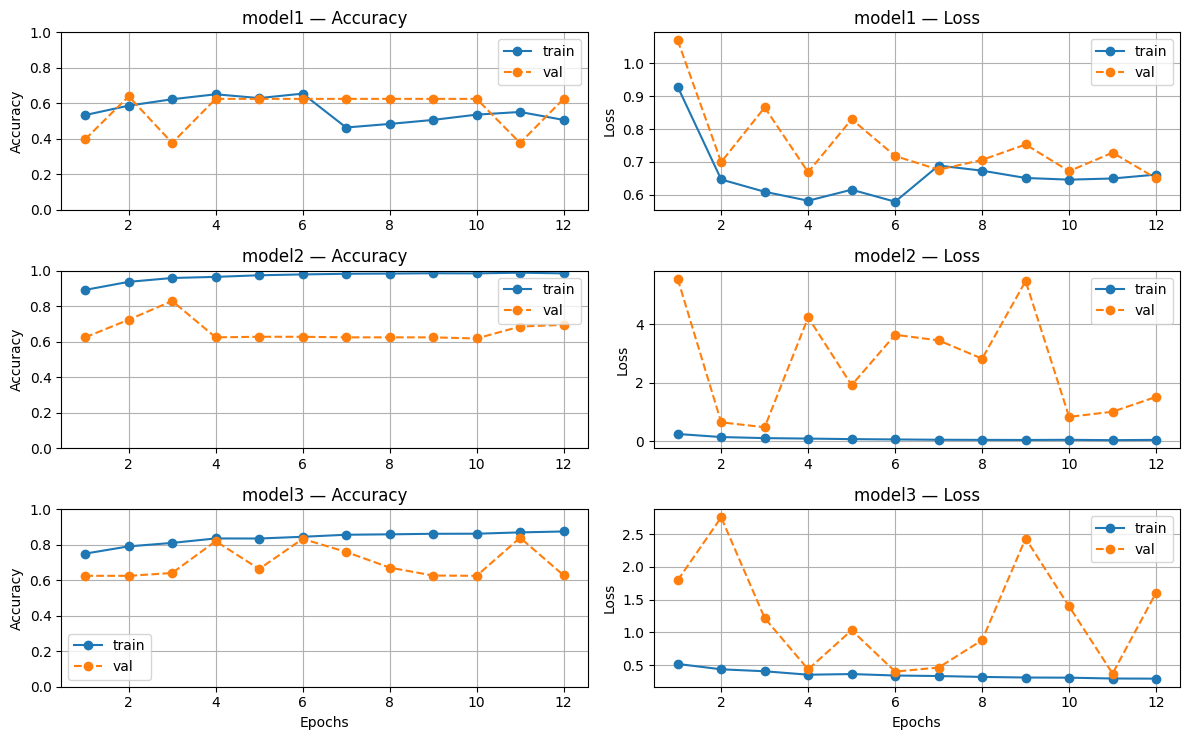

In [ ]:
histories = [history_1, history_2, history_3]   # add as many as you need
labels = ["model1", 'model2', 'model3']

plot_histories_rowwise(histories, labels=labels, figsize_per_row=(12, 2.5))


In [ ]:
metrics = best_model_1.evaluate(test_ds)
metrics

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.6093 - loss: 0.6581


[0.650486171245575, 0.625]

In [ ]:
metrics = best_model_2.evaluate(test_ds)
metrics

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.8451 - loss: 0.4704


[0.471915066242218, 0.8301281929016113]

In [ ]:
metrics = best_model_3.evaluate(test_ds)
metrics

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.8416 - loss: 0.3713


[0.37252357602119446, 0.8397436141967773]